In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import numpy as np
import matplotlib.pyplot as plt

In [25]:
def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

x = torch.randn(1, 255, 255, 3)
windows = window_partition(x, 1)
print(windows.shape)

torch.Size([65025, 1, 1, 3])


In [11]:
array = np.ones((8,8)).astype(int)
for i in range(8):
    for j in range(8):
        array[i][j] = i*8 + j

tensor = torch.from_numpy(array)
torch.roll(tensor, shifts=(-2, -2), dims=(0,1))

tensor([[18, 19, 20, 21, 22, 23, 16, 17],
        [26, 27, 28, 29, 30, 31, 24, 25],
        [34, 35, 36, 37, 38, 39, 32, 33],
        [42, 43, 44, 45, 46, 47, 40, 41],
        [50, 51, 52, 53, 54, 55, 48, 49],
        [58, 59, 60, 61, 62, 63, 56, 57],
        [ 2,  3,  4,  5,  6,  7,  0,  1],
        [10, 11, 12, 13, 14, 15,  8,  9]])

In [33]:
array = np.ones((8,8)).astype(int)
for i in range(8):
    for j in range(8):
        array[i][j] = i*7 + j
tensor = torch.from_numpy(array)

tensor.view(8//2,2, 8)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7],
         [ 7,  8,  9, 10, 11, 12, 13, 14]],

        [[14, 15, 16, 17, 18, 19, 20, 21],
         [21, 22, 23, 24, 25, 26, 27, 28]],

        [[28, 29, 30, 31, 32, 33, 34, 35],
         [35, 36, 37, 38, 39, 40, 41, 42]],

        [[42, 43, 44, 45, 46, 47, 48, 49],
         [49, 50, 51, 52, 53, 54, 55, 56]]])

attn shape: torch.Size([5, 5, 16, 16])
tensor([84, 83, 82,  ..., 86, 85, 84])
torch.Size([169, 5])


torch.Size([2401, 5])

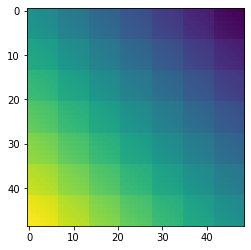

In [16]:
window_size = (7,7)
num_heads = 5
dim = 3
# 2*Wh-1 * 2*Ww-1, nH
relative_position_bias_table = nn.Parameter(torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), 5))

coords_h = torch.arange(window_size[0])
coords_w = torch.arange(window_size[1])

coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww

relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww

relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
relative_coords[:,:,0] += window_size[0] - 1  # shift to start from 0
relative_coords[:,:,1] += window_size[1] - 1
relative_coords[:,:,0] *= 2 * window_size[1] - 1
relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww

plt.imshow(relative_position_index)

x = torch.from_numpy(np.random.rand(5, 16, 20)).type(torch.FloatTensor)
B_, N, C = x.shape

qkv = nn.Linear(20, 3*20)
x_qkv = qkv(x).reshape(B_, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]  # make torchscript happy (cannot use tensor as tuple)

attn = (q @ k.transpose(-2, -1))

print(f'attn shape: {attn.shape}')

relative_position_bias = relative_position_bias_table[relative_position_index.view(-1)].view(window_size[0]*window_size[1], window_size[0]*window_size[1], -1)  # Wh*Ww, Wh*Ww, nH

print(relative_position_index.view(-1))
print(relative_position_bias_table.shape)
relative_position_bias_table[relative_position_index.view(-1)].shape

In [54]:
patch_size = 2
window_size = 4
input_resolution = (8,8)
H, W = input_resolution
shift_size = 2

img_mask = torch.zeros((1, H, W, 1))
cnt = 0
for h in (
        slice(0, -window_size),
        slice(-window_size, -shift_size),
        slice(-shift_size, None)):
    for w in (
            slice(0, -window_size),
            slice(-window_size, -shift_size),
            slice(-shift_size, None)):
        img_mask[:, h, w, :] = cnt
        cnt += 1

mask_windows = window_partition(img_mask, window_size)

print(mask_windows.permute(0,3,1,2))

mask_windows = mask_windows.view(-1, window_size * window_size)

print(f'mask_windows shape: {mask_windows.shape}')

attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)

print(mask_windows.unsqueeze(2).shape)

attn_mask[3]


tensor([[[[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]]],


        [[[1., 1., 2., 2.],
          [1., 1., 2., 2.],
          [1., 1., 2., 2.],
          [1., 1., 2., 2.]]],


        [[[3., 3., 3., 3.],
          [3., 3., 3., 3.],
          [6., 6., 6., 6.],
          [6., 6., 6., 6.]]],


        [[[4., 4., 5., 5.],
          [4., 4., 5., 5.],
          [7., 7., 8., 8.],
          [7., 7., 8., 8.]]]])
mask_windows shape: torch.Size([4, 16])
torch.Size([4, 16, 1])


tensor([[ 0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  3.,  3.,  4.,  4.,  3.,  3.,
          4.,  4.],
        [ 0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  3.,  3.,  4.,  4.,  3.,  3.,
          4.,  4.],
        [-1., -1.,  0.,  0., -1., -1.,  0.,  0.,  2.,  2.,  3.,  3.,  2.,  2.,
          3.,  3.],
        [-1., -1.,  0.,  0., -1., -1.,  0.,  0.,  2.,  2.,  3.,  3.,  2.,  2.,
          3.,  3.],
        [ 0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  3.,  3.,  4.,  4.,  3.,  3.,
          4.,  4.],
        [ 0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  3.,  3.,  4.,  4.,  3.,  3.,
          4.,  4.],
        [-1., -1.,  0.,  0., -1., -1.,  0.,  0.,  2.,  2.,  3.,  3.,  2.,  2.,
          3.,  3.],
        [-1., -1.,  0.,  0., -1., -1.,  0.,  0.,  2.,  2.,  3.,  3.,  2.,  2.,
          3.,  3.],
        [-3., -3., -2., -2., -3., -3., -2., -2.,  0.,  0.,  1.,  1.,  0.,  0.,
          1.,  1.],
        [-3., -3., -2., -2., -3., -3., -2., -2.,  0.,  0.,  1.,  1.,  0.,  0.,
          1.,  1.],
        [-